Icell =  -0.8
SOC_t =  100.01709401709402
Voc =  4.10306075966 when t =  0
V_cell =  3.82947675966
Icell =  0.8
SOC_t =  99.9841653425
Voc =  4.10275112784 when t =  1
V_cell =  3.82916712783
Icell =  2.4000000000000004
SOC_t =  99.9061528425
Voc =  4.10201829693 when t =  2
V_cell =  3.82843429692
Icell =  4.0
SOC_t =  99.7830565174
Voc =  4.10086404235 when t =  3
V_cell =  3.82728004234
Icell =  5.6000000000000005
SOC_t =  99.6148763669
Voc =  4.09929116017 when t =  4
V_cell =  3.82570716016
Icell =  7.2
SOC_t =  99.4016123911
Voc =  4.09730345993 when t =  5
V_cell =  3.82371945993
Icell =  8.8
SOC_t =  99.1432645901
Voc =  4.09490575478 when t =  6
V_cell =  3.82132175477
Icell =  10.399999999999999
SOC_t =  98.8398329638
Voc =  4.09210384895 when t =  7
V_cell =  3.81851984894
Icell =  12.000000000000002
SOC_t =  98.4913175122
Voc =  4.08890452271 when t =  8
V_cell =  3.8153205227
Icell =  13.600000000000001
SOC_t =  98.0977182353
Voc =  4.08531551453 when t =  9
V_cell =  3.81

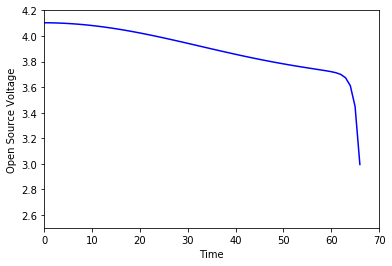

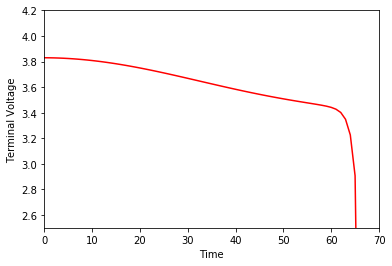

In [4]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

dischg_curr = 1.6
Cell_capacity = 1.300 #mah
Caps_max = Cell_capacity * 3600
K = 0.0008
C = 0.9248


#y1_0 = C * Caps_max
#y2_0 = (1 - C) * Caps_max

y1_0 = 2872.8 #2863.3
y2_0 = 234.17 #232.66
y0 = y2_0 + y1_0

def exp_const(t_p, t_i):
    ans = np.exp(-K * (t_p - t_i))
    return ans


def C_unavail(t0,t, I_cell):
    y1_t = y1_0 * exp_const(t,t0) + ((y0 * K * C - I_cell) * (1 - exp_const(t,t0))) / K - (I_cell * C * ( K * (t - t0)) - 1 + exp_const(t,t0))/K
    y2_t = y2_0 * exp_const(t,t0) + (y0 * (1 - C) * (1 - exp_const(t,t0))) - (I_cell * (1 - C)*(K * (t - t0) - 1 +  exp_const(t,t0)))/K
    Del_t = (y2_t / (1 - C)) - (y1_t / C)
    C_unavail_t0 = (1 - C) * (Del_t * exp_const(t,t0) + ((I_cell / C) * ( 1 - exp_const(t,t0)) /  K))
    C_unavailable = C_unavail_t0 * exp_const(t,t0) + ((I_cell / C) * (1 - C)* (1 - exp_const(t,t0)))/K
    return C_unavailable

def integrand(x):
    return x

def Calc_I_cell(t0, t):
    Dischg_I_cell, err = quad(integrand, t0, t)
    return(Dischg_I_cell)


def Calc_Voc(soc_t):
    voc = -1.031 * np.exp(-35 * soc_t) + 3.685 + 0.2156 * soc_t - 0.1178 * soc_t**2 + 0.3201 * soc_t**3
    return voc



def Calc_R_ser(SOC):
    #r_ser = b_0 * np.exp(-b_1 * SOC) + b_2 + (b_3 * SOC) - (b_4 * SOC**2) + (b_5 * SOC**3)
    r_ser = 0.1562 * np.exp(-24.37 * SOC) + 0.07446
    return r_ser


c_0 = 0.3208
c_1 = 29.14
c_2 = 0.04669


d_0 = -752.9
d_1 = 31.51
d_2 = 703.6


e_0 = 6.603
e_1 = 152.2
e_2 = 0.04984

f_0 = -60.56
f_1 = 27.12
f_2 = 4475

def Calc_V_trans_t(soc, i_cell, t, t0):
    R_trans_s = c_0 * np.exp(-c_1 * soc) + c_2
    C_trans_s = d_0 * np.exp(-d_1 * soc) + d_2
    R_trans_l = e_0 * np.exp(-e_1 * soc) + e_2
    C_trans_l = f_0 * np.exp(-f_1 * soc) + f_2
    tau_s = R_trans_s * C_trans_s
    tau_l = R_trans_l * C_trans_l
    V_trans_s = R_trans_s * i_cell * (1- np.exp(- (t - t0) * tau_s))
    V_trans_t = R_trans_l * i_cell * (1- np.exp(- (t - t0) * tau_l))
    V_trans = V_trans_s + V_trans_t
    return V_trans
    



SOC_init = 1

my_Tme_val = []
my_Vol_val = []
my_SOC_val = []
my_Vter_val = []


for tmax in range(0,100):
    I_cell =  dischg_curr * Calc_I_cell(tmax - 1, tmax)
    print("Icell = ", I_cell)
    if (tmax <= 0):
        C_unav = 0
    else:
        C_unav = C_unavail(tmax-1,tmax, I_cell)
        
    SOC_t = SOC_init - ((I_cell +  C_unav) / Caps_max)
    print("SOC_t = ", SOC_t * 100)
    VOl_oc = Calc_Voc(SOC_t)
    print("Voc = ",VOl_oc , "when t = ", tmax)
    R_series = Calc_R_ser(SOC_t)
    V_t = Calc_V_trans_t(SOC_t,dischg_curr, tmax, tmax -1 )
    V_cell = VOl_oc - (dischg_curr * R_series) - V_t
    print("V_cell = ", V_cell)
    if V_cell > 4.0:
        break
    my_Vter_val.append(V_cell)
    my_Vol_val.append(VOl_oc)
    my_Tme_val.append(tmax)
    my_SOC_val.append(SOC_t)
    SOC_init = SOC_t

#print(my_SOC_val)
#print(my_Tme_val)
#print(my_Vol_val)
print(my_Vter_val)

plt.plot(my_Tme_val, my_Vol_val, 'b')
plt.axis([0, 70, 2.5, 4.2])
plt.xlabel("Time")
plt.ylabel("Open Source Voltage")
plt.show()


plt.plot(my_Tme_val, my_Vter_val, 'r')
plt.axis([0, 70, 2.5, 4.2])
plt.xlabel("Time")
plt.ylabel("Terminal Voltage")
plt.show()

